# Equipe

## Alisson Gabriel Domingos Vieira, Joás Gomes dos Santos e Matheus Oliveira de Arruda

# Modelagem de Linguagem Mascarada de Ponta a Ponta com BERT - Dataset IMDb

## Setup

In [ ]:
# Define qual backend o Keras deve usar. Neste caso, está sendo forçado a utilizar o TensorFlow como backend.
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

# Importa os principais módulos da biblioteca Keras para criação de modelos e camadas.
import keras
from keras import layers
from keras.layers import TextVectorization  # Camada responsável por transformar texto bruto em tokens vetorizados.

# Importa o decorador dataclass, que permite criar classes simples para armazenar configurações ou dados.
from dataclasses import dataclass

# Importa bibliotecas auxiliares:
import pandas as pd       # Biblioteca para análise e manipulação de dados, especialmente tabelas e DataFrames.
import numpy as np        # Biblioteca para computação numérica eficiente, trabalhando com arrays e operações vetoriais.
import glob               # Usada para buscar arquivos usando padrões no nome (ex: *.txt, *.csv).
import re                 # Usada para aplicar expressões regulares, muito útil em pré-processamento de texto.
from pprint import pprint # Usada para imprimir objetos Python de forma mais legível (útil para debugging).


## Setup de Configuração

In [ ]:
from dataclasses import dataclass

# Define uma classe de configuração usando o decorador @dataclass.
# Essa estrutura é útil para armazenar todos os hiperparâmetros do modelo de forma organizada.
@dataclass
class Config:
    # Tamanho máximo de tokens por sequência (limite de comprimento das frases para entrada no modelo)
    MAX_LEN = 256

    # Tamanho do lote (batch) utilizado durante o treinamento do modelo
    BATCH_SIZE = 32

    # Taxa de aprendizado (learning rate) usada pelo otimizador para ajustar os pesos do modelo
    LR = 0.001

    # Tamanho do vocabulário (número de tokens únicos que o modelo consegue representar)
    VOCAB_SIZE = 30000

    # Dimensão dos vetores de embedding e também da saída das atenções
    EMBED_DIM = 128

    # Número de cabeças na camada de atenção multi-cabeça (Multi-Head Attention)
    NUM_HEAD = 8

    # Dimensão intermediária da rede feedforward dentro dos blocos Transformer
    FF_DIM = 128

    # Número de blocos Transformer empilhados (equivale ao número de camadas no encoder)
    NUM_LAYERS = 1

# Cria uma instância da configuração que pode ser acessada em todo o script.
config = Config()


## Download e Descompactação do Dataset

In [ ]:
import urllib.request
import tarfile

# URL do dataset IMDB de análise de sentimentos (positivo/negativo), em formato compactado .tar.gz
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Nome do arquivo que será salvo localmente após o download
filename = "aclImdb_v1.tar.gz"

# Faz o download do arquivo a partir da URL e salva com o nome especificado
urllib.request.urlretrieve(url, filename)

# Abre o arquivo compactado .tar.gz e extrai seu conteúdo no diretório atual
with tarfile.open(filename, "r:gz") as tar:
    tar.extractall()


In [ ]:
# Função que recebe uma lista de arquivos de texto e retorna uma lista com todas as linhas de todos os arquivos.
def get_text_list_from_files(files):
    text_list = []
    for name in files:
        with open(name) as f:
            for line in f:
                text_list.append(line)  # Adiciona cada linha do arquivo na lista
    return text_list

# Função que carrega textos e rótulos de sentimento de uma pasta (train ou test) do dataset IMDB
def get_data_from_text_files(folder_name):
    # Coleta os caminhos dos arquivos de reviews positivas
    pos_files = glob.glob("aclImdb/" + folder_name + "/pos/*.txt")
    pos_texts = get_text_list_from_files(pos_files)

    # Coleta os caminhos dos arquivos de reviews negativas
    neg_files = glob.glob("aclImdb/" + folder_name + "/neg/*.txt")
    neg_texts = get_text_list_from_files(neg_files)

    # Cria um DataFrame com os textos e os respectivos rótulos:
    # 0 para positivo, 1 para negativo (inverso do comum, cuidado!)
    df = pd.DataFrame({
        "review": pos_texts + neg_texts,
        "sentiment": [0] * len(pos_texts) + [1] * len(neg_texts),
    })

    # Embaralha o DataFrame para evitar viés na ordem
    df = df.sample(len(df)).reset_index(drop=True)
    return df

# Carrega e prepara os conjuntos de treino e teste
train_df = get_data_from_text_files("train")
test_df = get_data_from_text_files("test")

# Junta todos os dados (útil para criar vocabulário ou análises globais)
all_data = pd.concat([train_df, test_df], ignore_index=True)


## Preparação do Dataset

In [ ]:
import tensorflow as tf

# Função de normalização personalizada para o TextVectorization
# - Converte para minúsculas
# - Remove tags HTML como <br />
# - Remove pontuações específicas
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(
        stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\^_`{|}~"), ""
    )

# Função para criar e configurar a camada de vetorizar texto do Keras
def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    """
    Cria uma camada de vetorizar texto (TextVectorization) com tokenização customizada.

    Args:
      texts (list): Lista de strings com os textos de entrada
      vocab_size (int): Tamanho máximo do vocabulário
      max_seq (int): Tamanho máximo de sequência
      special_tokens (list): Tokens especiais que devem ser incluídos no vocabulário

    Returns:
      TextVectorization: Camada configurada e adaptada ao vocabulário
    """
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)  # Aprende o vocabulário a partir dos dados

    # Insere token especial [MASK] manualmente no vocabulário
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer

# Cria a camada de vetorizar texto com o vocabulário aprendido dos dados
vectorize_layer = get_vectorize_layer(
    all_data.review.values.tolist(),
    config.VOCAB_SIZE,
    config.MAX_LEN,
    special_tokens=["[mask]"],
)

# Obtém o ID correspondente ao token [MASK]
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]

# Função para codificar textos em sequências de inteiros
def encode(texts):
    encoded_texts = vectorize_layer(texts)
    return encoded_texts.numpy()

# Função que aplica o esquema de mascaramento BERT:
# 15% dos tokens são candidatos a serem mascarados, com:
# - 90% substituídos por [MASK]
# - 10% substituídos por tokens aleatórios
# - Os restantes permanecem os mesmos
def get_masked_input_and_labels(encoded_texts):
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15  # Seleciona 15% para masking
    inp_mask[encoded_texts <= 2] = False  # Evita mascarar tokens especiais (padding, start, etc.)

    labels = -1 * np.ones(encoded_texts.shape, dtype=int)  # Inicializa com -1 (ignorar)
    labels[inp_mask] = encoded_texts[inp_mask]  # Salva os verdadeiros rótulos dos tokens mascarados

    # Aplica o token [MASK] em 90% dos tokens selecionados para masking
    encoded_texts_masked = np.copy(encoded_texts)
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[inp_mask_2mask] = mask_token_id

    # Substitui 10% por tokens aleatórios (entre 3 e o último ID do vocabulário)
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Define pesos das amostras (tokens) - só tokens com label válido contribuem para o loss
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # Retorna inputs com masking, rótulos originais e pesos
    y_labels = np.copy(encoded_texts)
    return encoded_texts_masked, y_labels, sample_weights

# Pré-processamento dos dados de treino para o classificador de sentimentos
x_train = encode(train_df.review.values)  # Transforma texto em sequências de IDs
y_train = train_df.sentiment.values
train_classifier_ds = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(1000)
    .batch(config.BATCH_SIZE)
)

# Pré-processamento dos dados de teste
x_test = encode(test_df.review.values)
y_test = test_df.sentiment.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(
    config.BATCH_SIZE
)

# Armazena o DataFrame bruto de teste para possível uso posterior no modelo end-to-end
test_raw_classifier_ds = test_df

# Gera dados de entrada para treinamento com Masked Language Modeling (MLM)
x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(
    x_all_review
)

# Cria dataset TensorFlow para o treinamento do modelo de linguagem
mlm_ds = tf.data.Dataset.from_tensor_slices(
    (x_masked_train, y_masked_labels, sample_weights)
)
mlm_ds = mlm_ds.shuffle(1000).batch(config.BATCH_SIZE)


## Criando o modelo BERT (Modelo de Pré-treinamento) para MLM

In [ ]:
import keras_nlp

# Função que define um bloco encoder do BERT (atenção + feedforward)
def bert_module(query, key, value, i):
    # Camada de Atenção Multi-Cabeça (self-attention)
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD,
        key_dim=config.EMBED_DIM // config.NUM_HEAD,  # divisão da dimensão entre as cabeças
        name=f"encoder_{i}_multiheadattention"
    )(query, key, value)

    # Dropout após a atenção
    attention_output = layers.Dropout(0.1, name=f"encoder_{i}_att_dropout")(attention_output)

    # Normalização + conexão residual
    attention_output = layers.LayerNormalization(
        epsilon=1e-6,
        name=f"encoder_{i}_att_layernormalization"
    )(query + attention_output)

    # Camada FeedForward: Dense → ReLU → Dense
    ffn = keras.Sequential(
        [
            layers.Dense(config.FF_DIM, activation="relu"),
            layers.Dense(config.EMBED_DIM),
        ],
        name=f"encoder_{i}_ffn"
    )
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name=f"encoder_{i}_ffn_dropout")(ffn_output)

    # Normalização + conexão residual após feedforward
    sequence_output = layers.LayerNormalization(
        epsilon=1e-6,
        name=f"encoder_{i}_ffn_layernormalization"
    )(attention_output + ffn_output)

    return sequence_output

# Função de perda para MLM: Entropia cruzada com pesos por token
loss_fn = keras.losses.SparseCategoricalCrossentropy(reduction=None)
loss_tracker = keras.metrics.Mean(name="loss")

# Modelo customizado para linguagem com máscara (MLM)
class MaskedLanguageModel(keras.Model):

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        # Calcula a perda por token e atualiza a métrica de loss
        loss = loss_fn(y, y_pred, sample_weight)
        loss_tracker.update_state(loss, sample_weight=sample_weight)
        return keras.ops.sum(loss)

    def compute_metrics(self, x, y, y_pred, sample_weight):
        # Retorna as métricas monitoradas (loss médio da época)
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # Necessário para o reset automático das métricas
        return [loss_tracker]

# Função que constrói o modelo de linguagem BERT-like com predição de tokens mascarados
def create_masked_language_bert_model():
    # Entrada: sequência de inteiros (IDs dos tokens)
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")

    # Embedding de palavras e de posições (keras-nlp)
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding")(inputs)
    position_embeddings = keras_nlp.layers.PositionEmbedding(
        sequence_length=config.MAX_LEN,
        name="position_embedding"
    )(word_embeddings)

    embeddings = word_embeddings + position_embeddings  # Soma embeddings + posição

    # Passa por blocos Transformer empilhados
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)

    # Camada final de predição com softmax sobre o vocabulário
    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(encoder_output)

    # Modelo final
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model

# Dicionários de conversão entre ID e token
id2token = dict(enumerate(vectorize_layer.get_vocabulary()))
token2id = {y: x for x, y in id2token.items()}

# Callback que gera e imprime predições para tokens mascarados ao final de cada época
class MaskedTextGenerator(keras.callbacks.Callback):
    def __init__(self, sample_tokens, top_k=5):
        self.sample_tokens = sample_tokens
        self.k = top_k

    def decode(self, tokens):
        # Converte uma sequência de IDs em texto
        return " ".join([id2token[t] for t in tokens if t != 0])

    def convert_ids_to_tokens(self, id):
        return id2token[id]

    def on_epoch_end(self, epoch, logs=None):
        # Faz predição usando o modelo
        prediction = self.model.predict(self.sample_tokens)

        # Localiza o índice do token [MASK] na sequência
        masked_index = np.where(self.sample_tokens == mask_token_id)
        masked_index = masked_index[1]  # Posição na sequência

        # Extrai a predição correspondente ao token [MASK]
        mask_prediction = prediction[0][masked_index]

        # Pega os top-k tokens mais prováveis para preencher a máscara
        top_indices = mask_prediction[0].argsort()[-self.k :][::-1]
        values = mask_prediction[0][top_indices]

        for i in range(len(top_indices)):
            p = top_indices[i]
            v = values[i]
            tokens = np.copy(sample_tokens[0])
            tokens[masked_index[0]] = p
            result = {
                "input_text": self.decode(sample_tokens[0].numpy()),
                "prediction": self.decode(tokens),
                "probability": v,
                "predicted mask token": self.convert_ids_to_tokens(p),
            }
            pprint(result)

# Exemplo de frase com [MASK] para o callback
sample_tokens = vectorize_layer(["I have watched this [mask] and it was awesome"])
generator_callback = MaskedTextGenerator(sample_tokens.numpy())

# Cria o modelo final
bert_masked_model = create_masked_language_bert_model()

# Mostra o resumo da arquitetura do modelo
bert_masked_model.summary()


## Treinamento

In [ ]:
# Treinamento do modelo BERT com Masked Language Modeling por 5 épocas.
# Durante o treinamento, o callback irá gerar predições para o token [MASK] ao final de cada época.
bert_masked_model.fit(
    mlm_ds,
    epochs=5,
    callbacks=[generator_callback]  # Callback para visualizar a predição do [MASK]
)

# Salva o modelo treinado no formato .keras (padrão moderno recomendado pelo Keras)
bert_masked_model.save("bert_mlm_imdb.keras")

## Fine-tune de um modelo de classificação de sentimentos

In [ ]:
# Carrega o modelo BERT pré-treinado com masked language modeling
# É necessário passar a classe customizada usada na definição original (MaskedLanguageModel)
mlm_model = keras.models.load_model(
    "bert_mlm_imdb.keras", custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)

# Extrai apenas a parte do encoder BERT (até a última normalização do encoder)
# Isso será reutilizado como extrator de features no modelo de classificação
pretrained_bert_model = keras.Model(
    mlm_model.input,
    mlm_model.get_layer("encoder_0_ffn_layernormalization").output
)

# Congela os pesos do encoder BERT para treinar só as camadas do classificador
pretrained_bert_model.trainable = False

In [ ]:
# Função que cria o modelo de classificação com base no encoder BERT já treinado
def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")
    sequence_output = pretrained_bert_model(inputs)  # Saída do encoder BERT

    # Aplica Global Max Pooling para condensar a sequência em um vetor fixo
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)

    # Camada densa intermediária
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)

    # Camada de saída binária com ativação sigmoide (classificação de sentimento)
    outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)

    # Define e compila o modelo
    classifer_model = keras.Model(inputs, outputs, name="classification")
    optimizer = keras.optimizers.Adam()
    classifer_model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",  # Saída binária (positivo/negativo)
        metrics=["accuracy"]
    )
    return classifer_model

# Cria o modelo de classificação
classifer_model = create_classifier_bert_model()
classifer_model.summary()  # Exibe a arquitetura do modelo

In [ ]:
# Treina o classificador com o encoder BERT congelado (apenas a parte final será ajustada)
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

In [ ]:
# Descongela o encoder BERT para realizar fine-tuning completo
pretrained_bert_model.trainable = True

# Recompila o modelo com novo otimizador
optimizer = keras.optimizers.Adam()
classifer_model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Realiza novo treinamento agora ajustando toda a arquitetura, incluindo o encoder
classifer_model.fit(
    train_classifier_ds,
    epochs=5,
    validation_data=test_classifier_ds,
)

## Modelo de ponta a ponta que incorpore a TextVectorizationcamada dentro do método evalaute e avaliar

In [ ]:
# Cria uma subclasse de keras.Model para avaliar diretamente um DataFrame com texto cru
# Essa abordagem permite usar `.evaluate()` com um DataFrame (em vez de tensor pré-processado)
class ModelEndtoEnd(keras.Model):
    
    def evaluate(self, inputs):
        # Pré-processa os dados de entrada (conversão de texto para IDs)
        features = encode(inputs.review.values)
        labels = inputs.sentiment.values
        
        # Cria um dataset pronto para avaliação
        test_classifier_ds = (
            tf.data.Dataset.from_tensor_slices((features, labels))
            .shuffle(1000)
            .batch(config.BATCH_SIZE)
        )
        
        # Chama o método de avaliação padrão da superclasse
        return super().evaluate(test_classifier_ds)

    # Método necessário para compatibilidade com a API do Keras
    def build(self, input_shape):
        self.built = True

In [ ]:
# Encapsula o modelo classificador em uma versão end-to-end,
# que aceita diretamente um DataFrame com texto cru (review, sentiment)
def get_end_to_end(model):
    # Reutiliza entradas e saídas do classificador treinado
    inputs = classifer_model.inputs[0]
    outputs = classifer_model.outputs

    # Cria o novo modelo baseado na classe customizada
    end_to_end_model = ModelEndtoEnd(inputs, outputs, name="end_to_end_model")

    # Compila o modelo com o mesmo otimizador e métricas
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    end_to_end_model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    
    return end_to_end_model

In [ ]:
# Cria o modelo final que aceita DataFrame com texto direto
end_to_end_classification_model = get_end_to_end(classifer_model)

# Avalia diretamente o DataFrame bruto (sem precisar codificar manualmente)
end_to_end_classification_model.evaluate(test_raw_classifier_ds)

# Modelagem de Linguagem Mascarada de Ponta a Ponta com BERT - Dataset Amazon Polarity (Hugging Face)

## Importações e Configurações

In [1]:
import os
import random
import re
from collections import defaultdict
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras import layers
from keras.layers import TextVectorization
import keras_nlp
from datasets import load_dataset
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

from dataclasses import dataclass

@dataclass
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 30000
    EMBED_DIM = 32
    NUM_HEAD = 4
    FF_DIM = 128
    NUM_LAYERS = 1

config = Config()

## Carregar Dataset Amazon Polarity

In [2]:
dataset = load_dataset("amazon_polarity")
train_ds = dataset["train"].shuffle(seed=42).select(range(40000))
test_ds = dataset["test"].shuffle(seed=42).select(range(10000))

train_df = pd.DataFrame({
    "review": train_ds["content"],
    "sentiment": train_ds["label"]
})

test_df = pd.DataFrame({
    "review": test_ds["content"],
    "sentiment": test_ds["label"]
})

all_data = pd.concat([train_df, test_df], ignore_index=True)

## Tokenização e Preparação dos Dados

In [3]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, "[%s]" % re.escape("!#$%&'()*+,-./:;<=>?@\\^_`{|}~"), "")

def get_vectorize_layer(texts, vocab_size, max_seq, special_tokens=["[MASK]"]):
    vectorize_layer = TextVectorization(
        max_tokens=vocab_size,
        output_mode="int",
        standardize=custom_standardization,
        output_sequence_length=max_seq,
    )
    vectorize_layer.adapt(texts)
    vocab = vectorize_layer.get_vocabulary()
    vocab = vocab[2 : vocab_size - len(special_tokens)] + ["[mask]"]
    vectorize_layer.set_vocabulary(vocab)
    return vectorize_layer

vectorize_layer = get_vectorize_layer(all_data.review.values.tolist(), config.VOCAB_SIZE, config.MAX_LEN)
mask_token_id = vectorize_layer(["[mask]"]).numpy()[0][0]

def encode(texts):
    return vectorize_layer(texts).numpy()

def get_masked_input_and_labels(encoded_texts):
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.15
    inp_mask[encoded_texts <= 2] = False
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    labels[inp_mask] = encoded_texts[inp_mask]
    encoded_texts_masked = np.copy(encoded_texts)
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[inp_mask_2mask] = mask_token_id
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(3, mask_token_id, inp_mask_2random.sum())
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0
    y_labels = np.copy(encoded_texts)
    return encoded_texts_masked, y_labels, sample_weights

x_train = encode(train_df.review.values)
y_train = train_df.sentiment.values
train_classifier_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(config.BATCH_SIZE)

x_test = encode(test_df.review.values)
y_test = test_df.sentiment.values
test_classifier_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(config.BATCH_SIZE)

x_all_review = encode(all_data.review.values)
x_masked_train, y_masked_labels, sample_weights = get_masked_input_and_labels(x_all_review)
mlm_ds = tf.data.Dataset.from_tensor_slices((x_masked_train, y_masked_labels, sample_weights)).shuffle(1000).batch(config.BATCH_SIZE)

2025-04-22 20:56:25.846964: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-22 20:56:25.847476: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-22 20:56:25.848171: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-22 20:56:25.848858: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-22 20:56:25.848885: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Definição do Modelo BERT (MLM)

In [6]:
class MaskedLanguageModel(keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def compute_loss(self, x=None, y=None, y_pred=None, sample_weight=None):
        loss = keras.losses.SparseCategoricalCrossentropy(reduction=None)(y, y_pred, sample_weight)
        self.loss_tracker.update_state(loss, sample_weight=sample_weight)
        return keras.ops.sum(loss)

    def compute_metrics(self, x, y, y_pred, sample_weight):
        return {"loss": self.loss_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker]

def bert_module(query, key, value, i):
    attention_output = layers.MultiHeadAttention(
        num_heads=config.NUM_HEAD, 
        key_dim=config.EMBED_DIM // config.NUM_HEAD, 
        name=f"encoder_{i}_multiheadattention"
    )(query, key, value)
    attention_output = layers.Dropout(0.1, name=f"encoder_{i}_att_dropout")(attention_output)
    attention_output = layers.LayerNormalization(epsilon=1e-6, name=f"encoder_{i}_att_layernormalization")(query + attention_output)
    ffn = keras.Sequential([layers.Dense(config.FF_DIM, activation="relu"), layers.Dense(config.EMBED_DIM)], name=f"encoder_{i}_ffn")
    ffn_output = ffn(attention_output)
    ffn_output = layers.Dropout(0.1, name=f"encoder_{i}_ffn_dropout")(ffn_output)
    sequence_output = layers.LayerNormalization(epsilon=1e-6, name=f"encoder_{i}_ffn_layernormalization")(attention_output + ffn_output)
    return sequence_output

def create_masked_language_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")
    word_embeddings = layers.Embedding(config.VOCAB_SIZE, config.EMBED_DIM, name="word_embedding")(inputs)
    position_embeddings = keras_nlp.layers.PositionEmbedding(sequence_length=config.MAX_LEN, name="position_embedding")(word_embeddings)
    embeddings = word_embeddings + position_embeddings
    encoder_output = embeddings
    for i in range(config.NUM_LAYERS):
        encoder_output = bert_module(encoder_output, encoder_output, encoder_output, i)
    mlm_output = layers.Dense(config.VOCAB_SIZE, name="mlm_cls", activation="softmax")(encoder_output)
    mlm_model = MaskedLanguageModel(inputs, mlm_output, name="masked_bert_model")
    optimizer = keras.optimizers.Adam(learning_rate=config.LR)
    mlm_model.compile(optimizer=optimizer)
    return mlm_model

## Treinar MLM e Salvar Encode

In [7]:
mlm_model = create_masked_language_bert_model()
mlm_model.fit(mlm_ds, epochs=5)
mlm_model.save("bert_mlm_amazon.keras")

Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 408s 259ms/step - loss: 7.4009
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 450s 288ms/step - loss: 6.5412
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 429s 275ms/step - loss: 6.2111
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 410s 262ms/step - loss: 5.9508
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 415s 265ms/step - loss: 5.7693


## Carregar o Encoder (MLM) e Criar o Classificador

In [8]:
mlm_model = keras.models.load_model(
    "bert_mlm_amazon.keras",
    custom_objects={"MaskedLanguageModel": MaskedLanguageModel}
)

pretrained_bert_model = keras.Model(
    mlm_model.input,
    mlm_model.get_layer("encoder_0_ffn_layernormalization").output
)

pretrained_bert_model.trainable = False

## Definição do Classificador

In [9]:
def create_classifier_bert_model():
    inputs = layers.Input((config.MAX_LEN,), dtype="int64")
    sequence_output = pretrained_bert_model(inputs)
    pooled_output = layers.GlobalMaxPooling1D()(sequence_output)
    hidden_layer = layers.Dense(64, activation="relu")(pooled_output)
    outputs = layers.Dense(1, activation="sigmoid")(hidden_layer)
    model = keras.Model(inputs, outputs, name="classification")
    model.compile(optimizer=keras.optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])
    return model

classifer_model = create_classifier_bert_model()

## Treinar o Classficador (Encoder Congelado Primeiro)

In [10]:
classifer_model.fit(train_classifier_ds, epochs=5, validation_data=test_classifier_ds)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 32ms/step - accuracy: 0.5725 - loss: 0.7061 - val_accuracy: 0.5877 - val_loss: 0.6790
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.6176 - loss: 0.6521 - val_accuracy: 0.6014 - val_loss: 0.6661
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 37s 29ms/step - accuracy: 0.6248 - loss: 0.6474 - val_accuracy: 0.6346 - val_loss: 0.6395
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.6238 - loss: 0.6476 - val_accuracy: 0.6245 - val_loss: 0.6471
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 36s 29ms/step - accuracy: 0.6278 - loss: 0.6438 - val_accuracy: 0.6149 - val_loss: 0.6527


## Destravar o Encoder para Fine-Tuning

In [11]:
pretrained_bert_model.trainable = True

classifer_model.compile(optimizer=keras.optimizers.Adam(learning_rate=config.LR), loss="binary_crossentropy", metrics=["accuracy"])

classifer_model.fit(train_classifier_ds, epochs=5, validation_data=test_classifier_ds)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 74ms/step - accuracy: 0.7495 - loss: 0.4995 - val_accuracy: 0.8420 - val_loss: 0.3600
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 92s 74ms/step - accuracy: 0.8696 - loss: 0.3064 - val_accuracy: 0.8470 - val_loss: 0.3743
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 95s 76ms/step - accuracy: 0.9177 - loss: 0.2074 - val_accuracy: 0.8369 - val_loss: 0.4366
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 92s 73ms/step - accuracy: 0.9524 - loss: 0.1264 - val_accuracy: 0.8302 - val_loss: 0.5473
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 92s 73ms/step - accuracy: 0.9748 - loss: 0.0719 - val_accuracy: 0.8216 - val_loss: 0.7310


## Salvar os Pesos do Classificador (Segurança para evitar perda de treino)

In [13]:
# Salvar apenas os pesos do classificador
classifer_model.save_weights("classifer_model.weights.h5")

# Treinamento dos dois modelos de Markov (positivo e negativo)

In [14]:
from collections import defaultdict

def train_markov_model(texts, n=2):
    model = defaultdict(list)
    for text in texts:
        words = text.split()
        for i in range(len(words) - n):
            prefix = tuple(words[i:i+n])
            next_word = words[i+n]
            model[prefix].append(next_word)
    return model

def calculate_probability(model, text, n=2):
    words = text.split()
    score = 0
    for i in range(len(words) - n):
        prefix = tuple(words[i:i+n])
        next_word = words[i+n]
        next_words = model.get(prefix, [])
        count = next_words.count(next_word)
        total = len(next_words)
        if total > 0 and count > 0:
            score += count / total
    return score

## Treinar o Modelo de Markov para cada Classe

In [15]:
positive_texts = train_df[train_df.sentiment == 1].review.values.tolist()
negative_texts = train_df[train_df.sentiment == 0].review.values.tolist()

markov_model_pos = train_markov_model(positive_texts, n=2)
markov_model_neg = train_markov_model(negative_texts, n=2)

## Função de Classificação usando Markov

In [16]:
def classify_markov(text, pos_model, neg_model):
    pos_score = calculate_probability(pos_model, text)
    neg_score = calculate_probability(neg_model, text)
    return 1 if pos_score > neg_score else 0

## Classificação no Conjunto de Teste

In [17]:
y_pred_markov = [classify_markov(text, markov_model_pos, markov_model_neg) for text in test_df.review.values]

## Salvar os modelos de Markov

In [18]:
import pickle

with open("markov_model_pos.pkl", "wb") as f:
    pickle.dump(markov_model_pos, f)

with open("markov_model_neg.pkl", "wb") as f:
    pickle.dump(markov_model_neg, f)

### Carregar depois

In [19]:
with open("markov_model_pos.pkl", "rb") as f:
    markov_model_pos = pickle.load(f)

with open("markov_model_neg.pkl", "rb") as f:
    markov_model_neg = pickle.load(f)

# Avaliação, Métricas e Comparação entre BERT e Markov

## Geração das Predições do BERT (garantindo que tudo esteja atualizado)

In [20]:
y_pred_bert_probs = classifer_model.predict(x_test)
y_pred_bert = (y_pred_bert_probs > 0.5).astype(int).flatten()

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


## Métricas de Desempenho (Accuracy, Precision, Recall, F1) *Ambos*

In [21]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

# BERT
accuracy_bert = accuracy_score(y_test, y_pred_bert)
precision_bert = precision_score(y_test, y_pred_bert)
recall_bert = recall_score(y_test, y_pred_bert)
f1_bert = f1_score(y_test, y_pred_bert)

# Markov
accuracy_markov = accuracy_score(test_df.sentiment.values, y_pred_markov)
precision_markov = precision_score(test_df.sentiment.values, y_pred_markov)
recall_markov = recall_score(test_df.sentiment.values, y_pred_markov)
f1_markov = f1_score(test_df.sentiment.values, y_pred_markov)

## Tabela Final de Comparação entre BERT e Markov

In [22]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Modelo": ["BERT", "Markov"],
    "Accuracy": [accuracy_bert, accuracy_markov],
    "Precision": [precision_bert, precision_markov],
    "Recall": [recall_bert, recall_markov],
    "F1-Score": [f1_bert, f1_markov]
})

print(comparison_df)

   Modelo  Accuracy  Precision    Recall  F1-Score
0    BERT    0.8216   0.841653  0.795914  0.818145
1  Markov    0.6968   0.700839  0.695557  0.698188


## Matrz de Confusão dos Dois Modelos

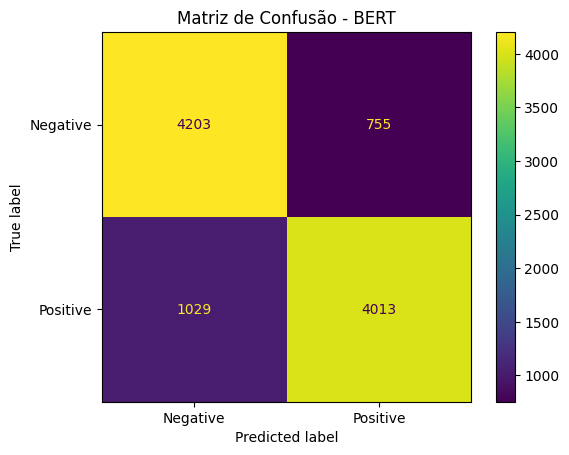

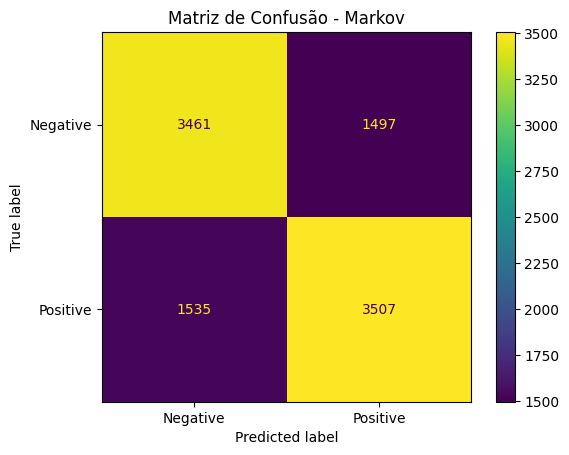

In [23]:
# Confusion Matrix BERT
cm_bert = confusion_matrix(y_test, y_pred_bert)
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=["Negative", "Positive"])
disp_bert.plot()
plt.title("Matriz de Confusão - BERT")
plt.show()

# Confusion Matrix Markov
cm_markov = confusion_matrix(test_df.sentiment.values, y_pred_markov)
disp_markov = ConfusionMatrixDisplay(confusion_matrix=cm_markov, display_labels=["Negative", "Positive"])
disp_markov.plot()
plt.title("Matriz de Confusão - Markov")
plt.show()

## Gráfico de Barras das Métricas

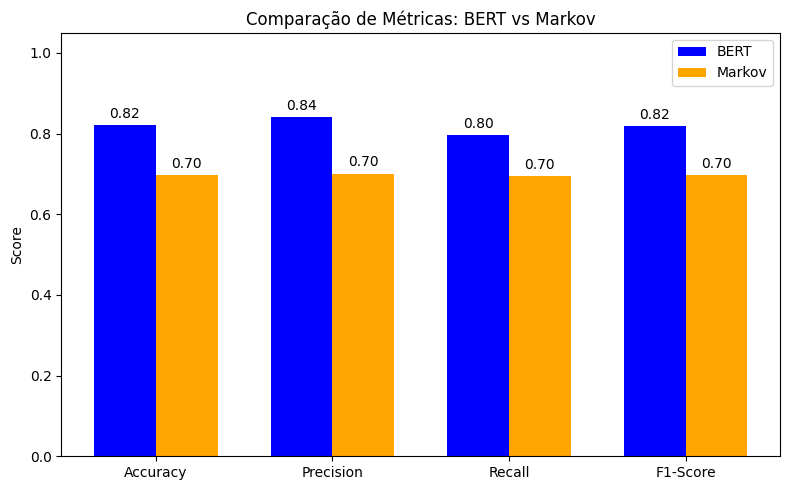

In [24]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
bert_metrics = [accuracy_bert, precision_bert, recall_bert, f1_bert]
markov_metrics = [accuracy_markov, precision_markov, recall_markov, f1_markov]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, bert_metrics, width, label='BERT', color='blue')
rects2 = ax.bar(x + width/2, markov_metrics, width, label='Markov', color='orange')

ax.set_ylabel('Score')
ax.set_title('Comparação de Métricas: BERT vs Markov')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

## Exemplos de Erros para Avaliação Qualitativa

In [25]:
bert_errors = test_df[(y_pred_bert != y_test)]
markov_errors = test_df[(np.array(y_pred_markov) != test_df.sentiment.values)]

print("===== Exemplos de erros do BERT =====")
print(bert_errors.sample(5))

print("===== Exemplos de erros do Markov =====")
print(markov_errors.sample(5))

===== Exemplos de erros do BERT =====
                                                 review  sentiment
7097  I'm a congenital heart surgeon.This computer i...          1
388   I got these specifically for polishing off bla...          1
1978  I had high expectations when i ordered this DV...          0
9102  This is not a machine to buy if you're trying ...          1
4323  Okay, I read all of the Angels book Lurlene wr...          1
===== Exemplos de erros do Markov =====
                                                 review  sentiment
4464  leave it to milton friedman to make an airtigh...          1
5205  Don't be fooled--this is NOT a Mott the Hoople...          0
6282  This is yet another re-compilation of the bad ...          0
1722  After hearing how Russian Doctors use sound to...          0
9875  I just received the Brenthaven Sleeve for the ...          0
